# Exploratory data analysis

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_theme("notebook")

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

%matplotlib inline

In [58]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

# Import data sets

In [59]:
train_path = os.path.join('s3://', bucket, 'train.csv')
train = pd.read_csv(train_path)
print("Train dataset has: {} rows and {} columns".format(train.shape[0], train.shape[1]))
train.head()

Train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,low,Ideal,E,SI2,61.746807,54.657905,308.000982,5.087917,4.074514,2.640541
1,low,Premium,E,SI1,60.811398,61.500866,311.972787,4.935622,4.002951,2.566944
2,low,Good,E,VS1,57.463159,64.434528,306.322634,4.836103,3.966641,2.238341
3,low,Premium,I,VS2,62.110048,57.770527,308.236569,5.107297,3.941319,2.476921
4,low,Good,J,SI2,63.367713,58.202601,317.016683,5.348185,4.276069,2.899670


In [60]:
test_path = os.path.join('s3://', bucket, 'test.csv')
test = pd.read_csv(test_path)
print("Test dataset has: {} rows and {} columns".format(test.shape[0], test.shape[1]))
test.head()

Test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,NaN,Very Good,H,VS1,57.864170,60.877015,312.033984,5.129112,4.053714,2.357030
1,NaN,Good,J,SI1,64.608550,54.823918,321.453496,5.225114,4.298209,2.687131
2,NaN,Ideal,J,VS1,63.515610,56.243782,329.006797,4.946555,3.988157,2.388180
3,NaN,Premium,E,SI2,60.521578,61.481931,322.079563,4.892611,3.802079,2.290711
4,NaN,Premium,E,I1,60.880893,57.886154,318.535695,5.500656,4.425004,2.825893


# Features analysis

In [61]:
print('Train dataset shape:')
print(train.shape)
print('Info dataset:')
train.info()

Train dataset shape:
(43170, 10)
Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43170 entries, 0 to 43169
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat_class  43170 non-null  object 
 1   cut          42311 non-null  object 
 2   color        41046 non-null  object 
 3   clarity      41871 non-null  object 
 4   depth        40582 non-null  float64
 5   table        42735 non-null  float64
 6   price        39527 non-null  float64
 7   x            43128 non-null  float64
 8   y            42615 non-null  float64
 9   z            42327 non-null  float64
dtypes: float64(6), object(4)
memory usage: 3.3+ MB


In [62]:
train.describe()

,depth,table,price,x,y,z
count,40582.000000,42735.000000,39527.000000,43128.000000,42615.000000,42327.000000
mean,61.750269,57.453911,3911.581104,6.730082,5.733144,3.538764
std,1.634396,2.255019,3974.925834,1.125322,1.125156,0.724071
min,43.158207,43.321167,306.322634,0.935423,-0.165995,-0.253948
25%,60.805377,55.888065,938.079683,5.703162,4.705580,2.917361
50%,61.807778,57.164165,2392.586880,6.684222,5.687529,3.499653
75%,62.738652,58.878595,5309.267548,7.546948,6.547369,4.057237
max,78.111790,94.856676,18819.121864,11.642644,10.542158,31.908393


**Target**: carat_class \
**Numerical features**: depth, table, price, x, y, z \
**Categorical features**: cut, color, clarity

### Plot pairwise relationships in a dataset

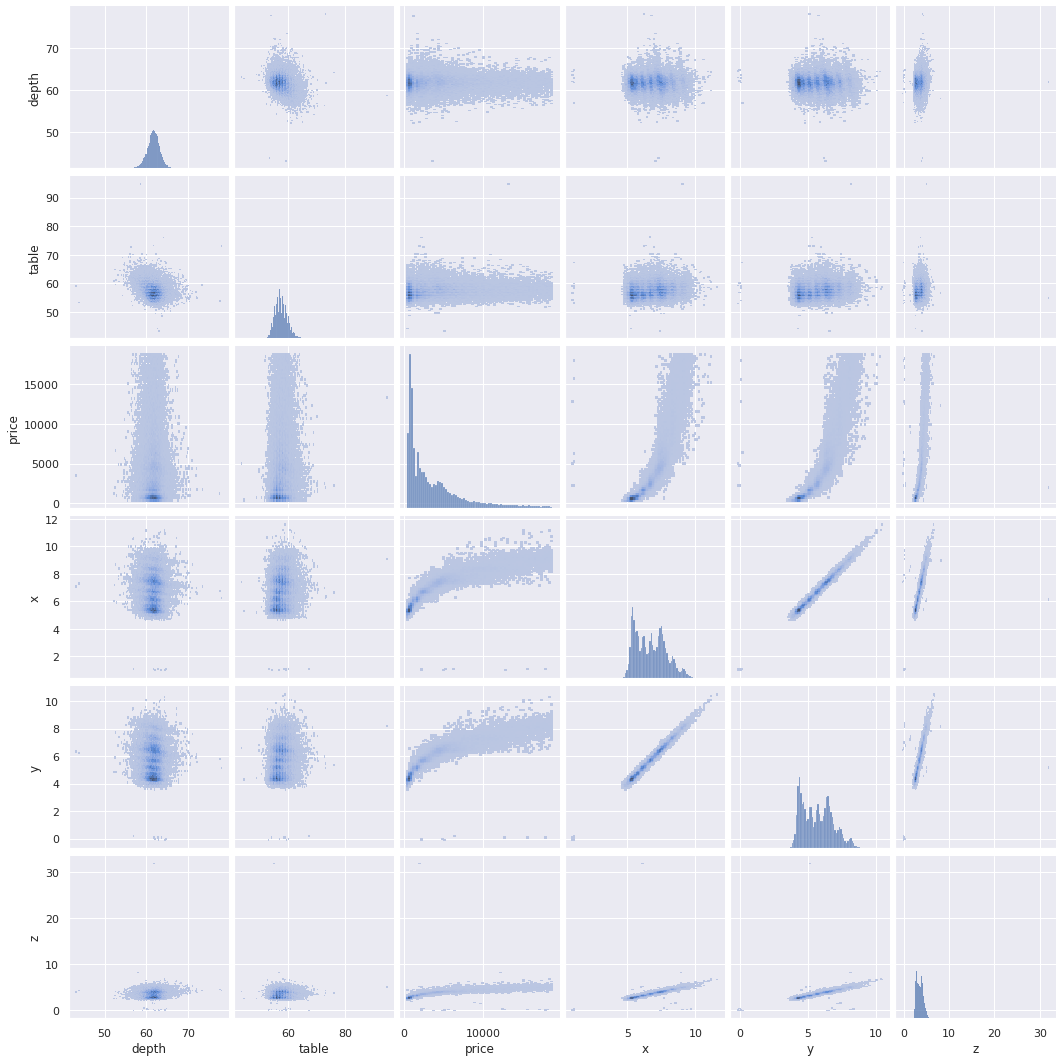

In [63]:
sns.pairplot(train, kind = 'hist')

In [64]:
pd.options.mode.chained_assignment = None

## Null values

In [65]:
print('NULL values for each column:')
null = train.isna().sum()
print(round(null, 2))

NULL values for each column:
carat_class       0
cut             859
color          2124
clarity        1299
depth          2588
table           435
price          3643
x                42
y               555
z               843
dtype: int64


In [66]:
print('Percentages of NULL values for each column:')
null = train.isna().sum()*100/len(train)
print(round(null, 2))

Percentages of NULL values for each column:
carat_class    0.00
cut            1.99
color          4.92
clarity        3.01
depth          5.99
table          1.01
price          8.44
x              0.10
y              1.29
z              1.95
dtype: float64


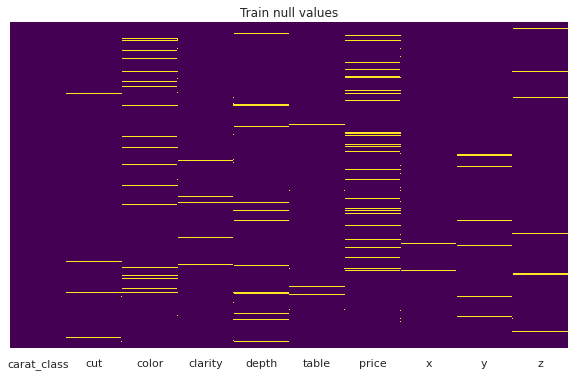

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Train null values')
plt.show()

In [68]:
print('Percentages of NULL values for each column:')
null = test.isna().sum()*100/len(test)
print(round(null, 2))

Percentages of NULL values for each column:
carat_class    100.00
cut              2.03
color            5.32
clarity          2.96
depth            6.02
table            0.97
price            8.74
x                0.10
y                1.36
z                2.18
dtype: float64


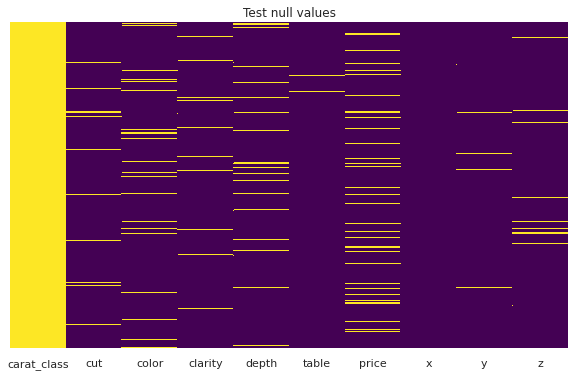

In [69]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Test null values')
plt.show()

## Carat_class (Target)


In [70]:
target = 'carat_class'
train[target] = train[target].astype('category')

print('Count values for "' + target+'":')
print(train[target].value_counts())
print('\nPercentages:')
print(round(train[target].value_counts()/train.shape[0]*100, 2))

Count values for "carat_class":
low       25498
medium    15893
high       1779
Name: carat_class, dtype: int64

Percentages:
low       59.06
medium    36.81
high       4.12
Name: carat_class, dtype: float64


<Figure size 432x432 with 0 Axes>

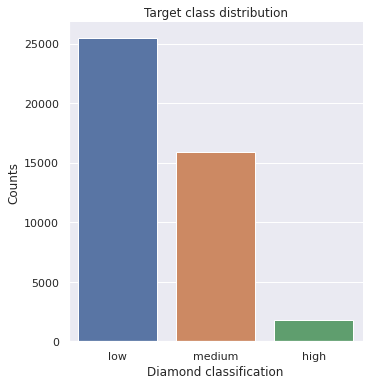

In [71]:
plt.figure(figsize=(6, 6))
fig = sns.catplot(x=target, kind="count", data=train, order = ['low','medium','high'])
fig.set_axis_labels("Diamond classification", "Counts")
plt.title("Target class distribution")
plt.show()

In [72]:
tmp_df = train.copy()

## Cut analysis

In [73]:
feature = 'cut'
order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

In [74]:
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())

Count of NULL values of "cut" feature:
859


In [75]:
print('Value counts:')
display(train[feature].value_counts(dropna = False))

Value counts:


Ideal        16892
Premium      10771
Very Good     9508
Good          3885
Fair          1255
NaN            859
Name: cut, dtype: int64

In [76]:
print('Relevant statistical values:')
print(train[feature].describe())

Relevant statistical values:
count     42311
unique        5
top       Ideal
freq      16892
Name: cut, dtype: object


## Contingency table
Matrix that displays the multivariate frequency distribution of the variables. It provides a basic picture of the interrelation between two variables and can help find interactions between them. 

#### Reference: "Contingency table", https://en.wikipedia.org/wiki/Contingency_table

In [77]:
print('Crosstab "'+feature+' '+target+'":')
df_contingency = pd.crosstab(train[target], train[feature], margins = False)
display(df_contingency)

Crosstab "cut carat_class":


cut,Fair,Good,Ideal,Premium,Very Good
carat_class,,,,,
high,133,162,420,663,366
low,432,1957,11871,5364,5389
medium,690,1766,4601,4744,3753


## **chi2 contingency and p-value**
**Pearson's chi-squared test** is a statistical test applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance.
It tests a null hypothesis stating that the frequency distribution of certain events observed in a sample is consistent with a particular theoretical distribution: it proposes that there is no difference between certain characteristics of a population. \
The null hypothesis is a type of hypothesis used in statistics that proposes that there is no difference between certain characteristics of a population (or data-generating process).  
\
In null hypothesis significance testing, the **p-value** is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. A very small p-value means that such an extreme observed outcome would be very unlikely under the null hypothesis.
\
\
The p-value tests the importance of the feature related to the target. If p-value is greater that 0.05 we can reject the null hypothesis, otherwise, the Chi2 value is not useful.

#### Reference: "Pearson’s chi-squared test", https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test \
#### Reference: "p-value", https://en.wikipedia.org/wiki/P-value

In [78]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(df_contingency, correction=False)
print('Chi2 test statistic: {:.5f}'.format(chi2))
print('P-Value: {:.5f}'.format(p))

Chi2 test statistic: 1834.71579
P-Value: 0.00000


**p-value is 0 so we can accept  H0**

### Count the feature values for each label

Count "cut" values for each "carat_class":


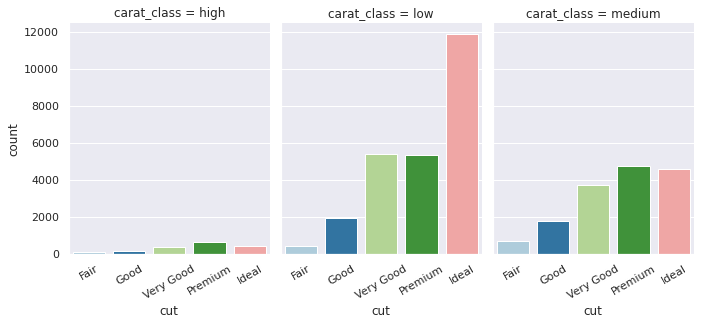

In [79]:
print('Count "'+feature+'" values for each "'+target+'":')
sns.set_palette("Paired")
g = sns.catplot(x=feature, col=target, data=train, col_wrap=3, kind="count", height=4, aspect=.8, order = order)\
    .set_xticklabels(rotation=30)

### Fill the NaN values

In [80]:
tmp_df[feature] = train[feature]
tmp_df[feature].fillna('NaN',inplace = True)

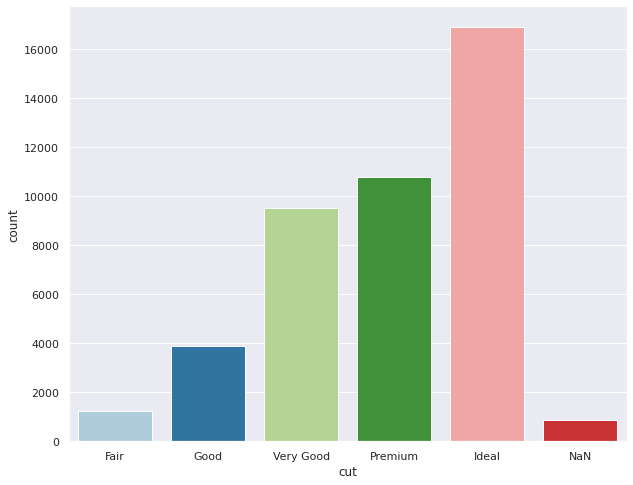

In [81]:
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.countplot(data = tmp_df, x = feature,
             order = order + ['NaN'])
plt.show()

In [82]:
#Fill NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mode()[0],inplace = False) # fill null values with the mode 

### Encode categorical feature

In [83]:
#Encoding
tmp_df[feature] = tmp_df[feature].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes

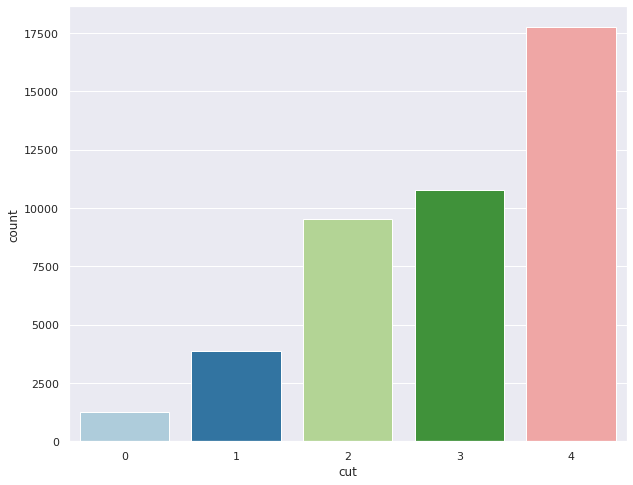

In [84]:
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.countplot(data = tmp_df, x = feature)
plt.show()

## Color analysis

In [85]:
feature = 'color'
order = ['J','I','H','G','F','E','D']
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Value counts:')
display(train[feature].value_counts(dropna = False))
print('Relevant statistical values:')
print(train[feature].describe())
print('Crosstab "'+feature+' '+target+'":')
df_contingency = pd.crosstab(train[target], train[feature], margins = False)
display(df_contingency)
chi2, p, dof, ex = chi2_contingency(df_contingency, correction=False)
print('Chi2 test statistic: {:.5f}'.format(chi2))
print('P-Value: {:.5f}'.format(p))

Count of NULL values of "color" feature:
2124
Value counts:


G      8472
E      7476
F      7305
H      6334
D      5167
I      4135
J      2157
NaN    2124
Name: color, dtype: int64

Relevant statistical values:
count     41046
unique        7
top           G
freq       8472
Name: color, dtype: object
Crosstab "color carat_class":


color,D,E,F,G,H,I,J
carat_class,,,,,,,
high,39,78,116,222,426,485,337
low,3691,5359,4651,5003,3032,1789,736
medium,1437,2039,2538,3247,2876,1861,1084


Chi2 test statistic: 3358.01643
P-Value: 0.00000


Count "color" values for each "carat_class":


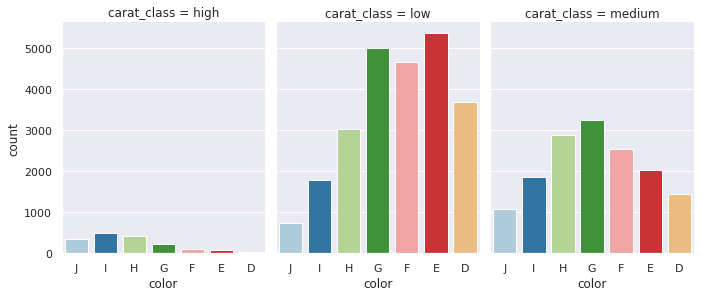

In [86]:
print('Count "'+feature+'" values for each "'+target+'":')
sns.set_palette("Paired")
g = sns.catplot(x=feature, col=target, data=train, col_wrap=3, kind="count", height=4, aspect=.8, order = order)

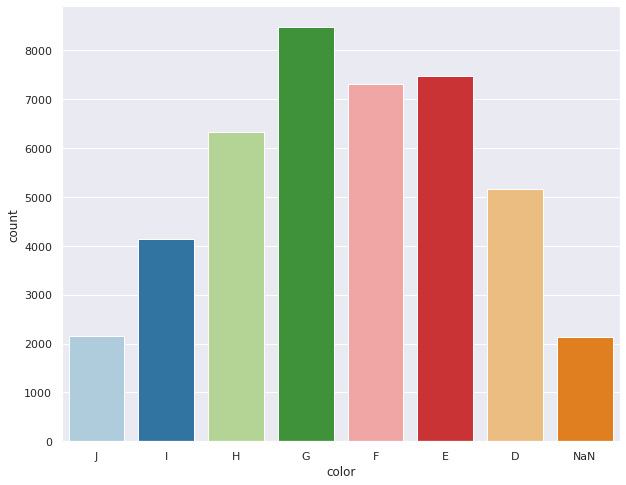

In [87]:
tmp_df[feature] = train[feature]
tmp_df[feature].fillna('NaN',inplace = True)
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.countplot(data = tmp_df, x = feature,
             order = order + ['NaN'])
plt.show()

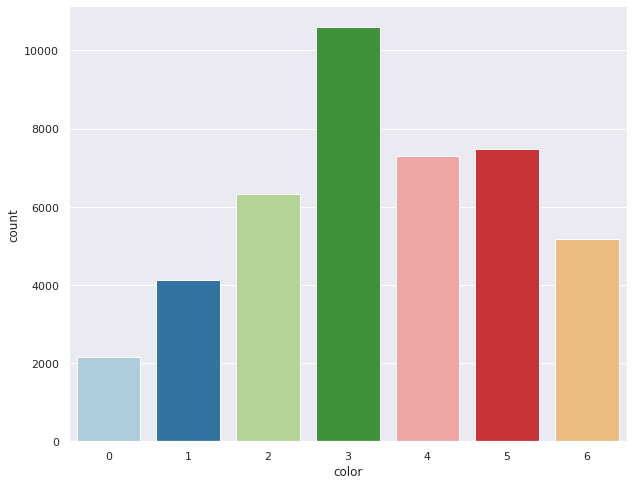

In [88]:
#Fill NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mode()[0]) # fill null values with the mode 
#Encoding
tmp_df[feature] = tmp_df[feature].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.countplot(data = tmp_df, x = feature)
plt.show()

## Clarity analysis

In [89]:
feature = 'clarity'
order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Value counts:')
display(train[feature].value_counts(dropna = False))
print('Relevant statistical values:')
print(train[feature].describe())
print('Crosstab "'+feature+' '+target+'":')
df_contingency = pd.crosstab(train[target], train[feature], margins = False)
display(df_contingency)
chi2, p, dof, ex = chi2_contingency(df_contingency, correction=False)
print('Chi2 test statistic: {:.5f}'.format(chi2))
print('P-Value: {:.5f}'.format(p))

Count of NULL values of "clarity" feature:
1299
Value counts:


SI1     10105
VS2      9626
SI2      7108
VS1      6306
VVS2     3965
VVS1     2852
IF       1340
NaN      1299
I1        569
Name: clarity, dtype: int64

Relevant statistical values:
count     41871
unique        8
top         SI1
freq      10105
Name: clarity, dtype: object
Crosstab "clarity carat_class":


clarity,I1,IF,SI1,SI2,VS1,VS2,VVS1,VVS2
carat_class,,,,,,,,
high,95,2,446,838,91,246,3,8
low,100,1138,5414,2312,4203,6012,2496,3044
medium,374,200,4245,3958,2012,3368,353,913


Chi2 test statistic: 5389.54003
P-Value: 0.00000


Count "clarity" values for each "carat_class":


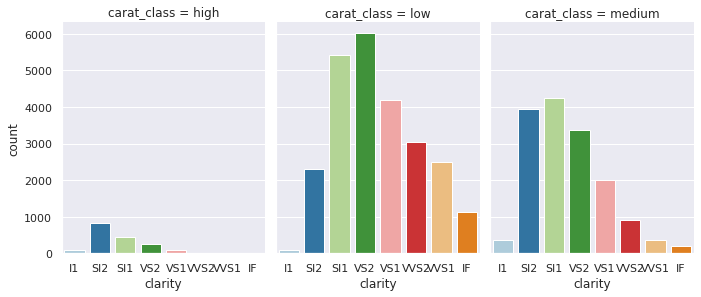

In [90]:
print('Count "'+feature+'" values for each "'+target+'":')
sns.set_palette("Paired")
g = sns.catplot(x=feature, col=target, data=train, col_wrap=3, kind="count", height=4, aspect=.8, order = order)

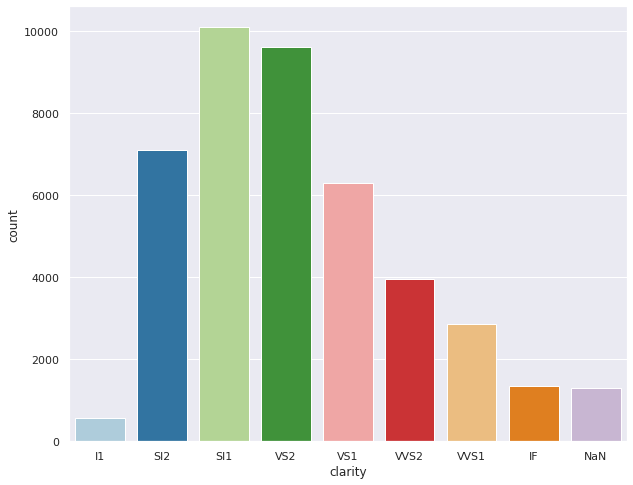

In [91]:
tmp_df[feature] = train[feature]
tmp_df[feature].fillna('NaN',inplace = True)
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.countplot(data = tmp_df, x = feature,
             order = order + ['NaN'])
plt.show()

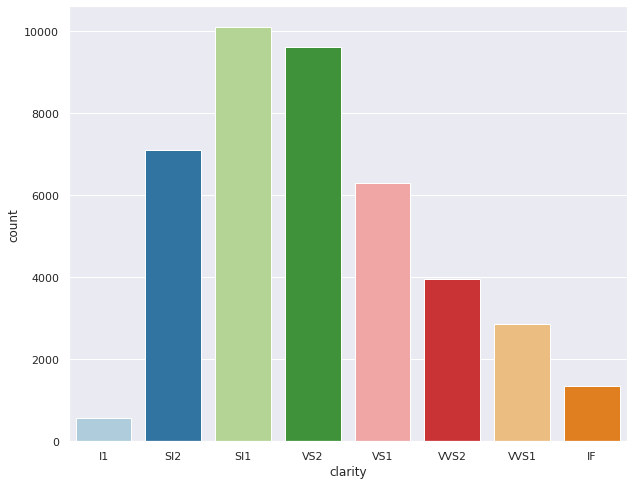

In [92]:
#Fill NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mode()[0]) # fill null values with the mode 
#Encoding
tmp_df[feature] = tmp_df[feature].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.countplot(data = train, x = feature, order = order ) 
plt.show()

## Depth analysis

In [93]:
feature = 'depth'
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Relevant statistical values:')
print(train[feature].describe())

Count of NULL values of "depth" feature:
2588
Relevant statistical values:
count    40582.000000
mean        61.750269
std          1.634396
min         43.158207
25%         60.805377
50%         61.807778
75%         62.738652
max         78.111790
Name: depth, dtype: float64


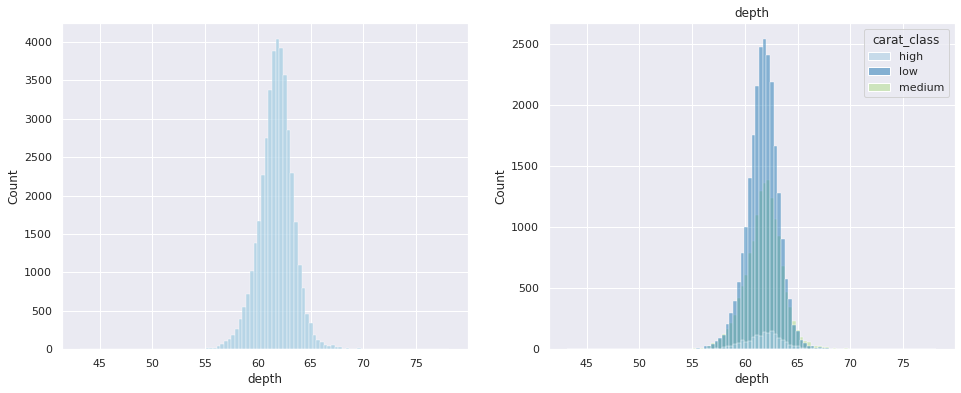

In [94]:
fig,ax = plt.subplots(1,2, figsize = (16,6))
bins = 100
sns.histplot(data = train, x = feature, bins = bins, ax = ax[0])
sns.histplot(data = train, x = feature, hue = target, bins = bins, ax = ax[1])
plt.title("{}".format(feature));

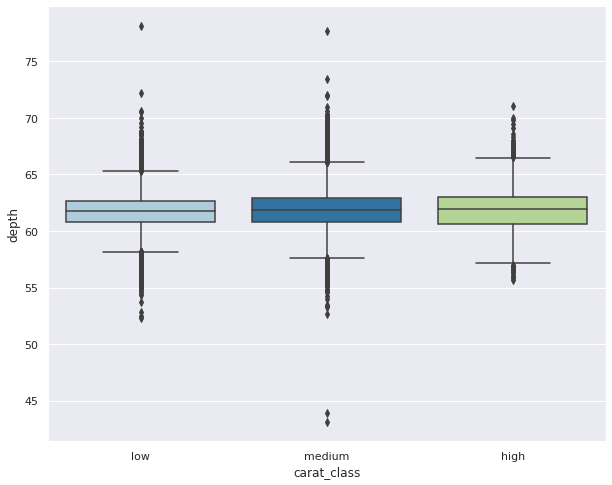

In [95]:
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.boxplot(x= target, y= feature, data=train, order = ['low', 'medium','high'])
plt.show()

For numerical values you can use a **boxplot** to see their distribution. The height of the box represents the **IQR**, the difference between **Quantile75** and **Quatile25**. With the bloxplot technique anomalies are all values lower than **Q1 - 1.5 * IQR** or greater than **Q3 + 1.5 * IQR**.  
The IQR is a measure of variability, based on dividing a data set into quartiles. Quartiles divide a rank-ordered data set into four equal parts. The values that separate parts are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively.
\
Quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities

In [96]:
# interquantile range 
Q1 = train[feature].quantile(0.25)
Q3 = train[feature].quantile(0.75)
IQR = Q3 - Q1
print('The IQR is:')
print(IQR)

The IQR is:
1.9332750981281706


In [97]:
#NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mean()) # fill null values with the mean 
        
#Anomalies
P10 = tmp_df[feature].quantile(0.1) 
P90 = tmp_df[feature].quantile(0.9) 
tmp_df[feature] = tmp_df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)

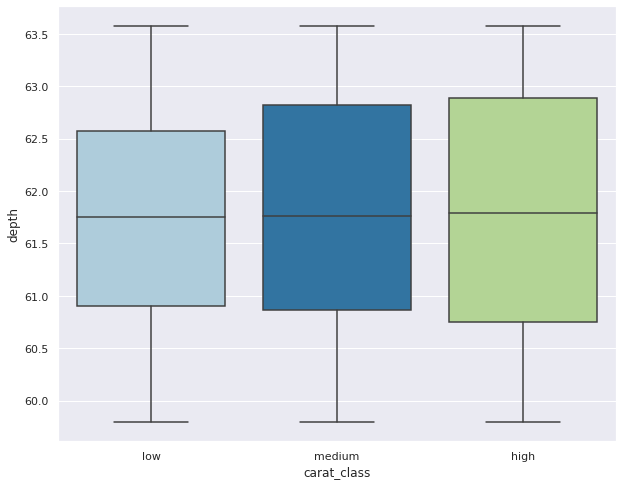

In [98]:
fig,ax = plt.subplots(1,1, figsize = (10,8))
sns.boxplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'])
plt.show()

## Table analysis

Count of NULL values of "table" feature:
435
Relevant statistical values:
count    42735.000000
mean        57.453911
std          2.255019
min         43.321167
25%         55.888065
50%         57.164165
75%         58.878595
max         94.856676
Name: table, dtype: float64


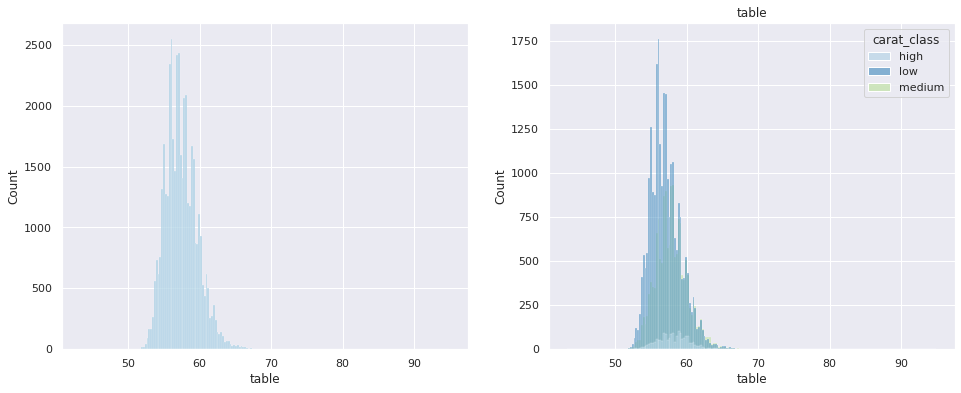

In [99]:
feature = 'table'
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Relevant statistical values:')
print(train[feature].describe())

fig,ax = plt.subplots(1,2, figsize = (16,6))
bins = 200
sns.histplot(data = train, x = feature, bins = bins, ax = ax[0])
sns.histplot(data = train, x = feature, hue = target, bins = bins, ax = ax[1])
plt.title("{}".format(feature));

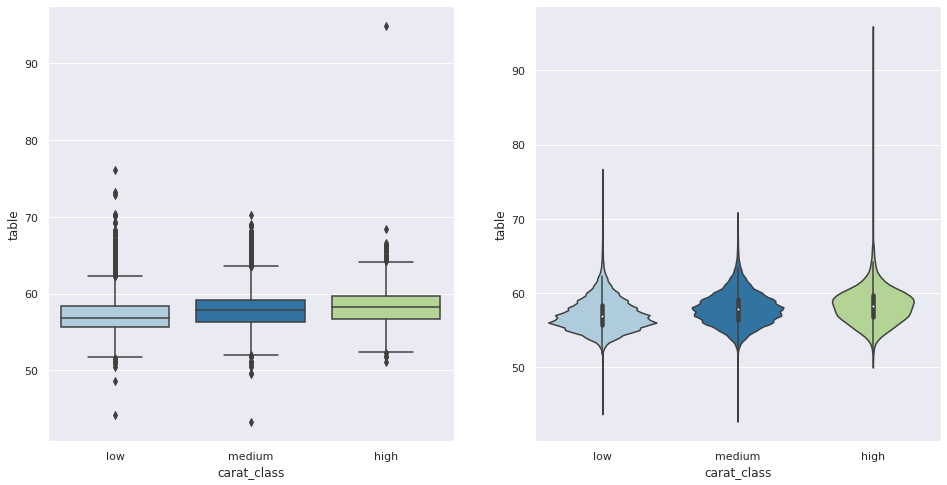

In [103]:
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

The IQR is:
2.9905303003895227


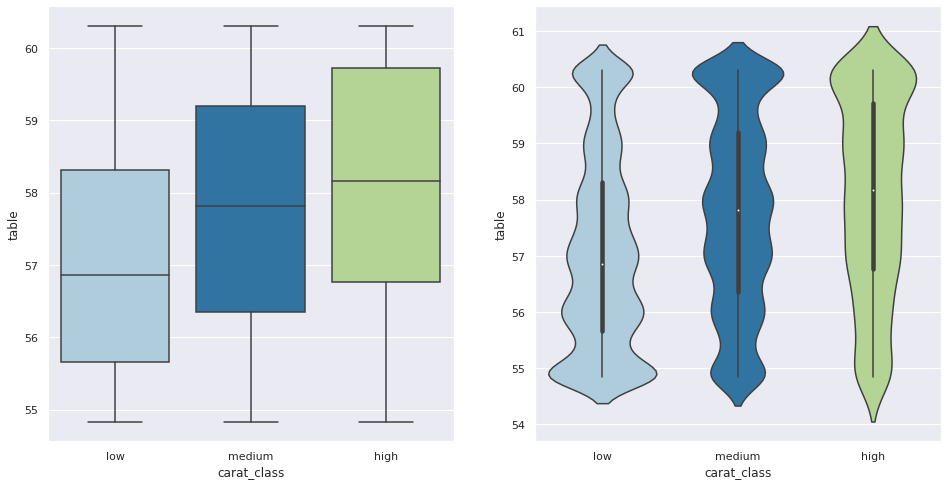

In [104]:
# interquantile range 
Q1 = train[feature].quantile(0.25)
Q3 = train[feature].quantile(0.75)
IQR = Q3 - Q1
print('The IQR is:')
print(IQR)

#NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mean()) # fill null values with the mean 
        
#Anomalies
P10 = tmp_df[feature].quantile(0.1) 
P90 = tmp_df[feature].quantile(0.9) 
tmp_df[feature] = tmp_df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

## Price analysis

Count of NULL values of "price" feature:
3643
Relevant statistical values:
count    39527.000000
mean      3911.581104
std       3974.925834
min        306.322634
25%        938.079683
50%       2392.586880
75%       5309.267548
max      18819.121864
Name: price, dtype: float64


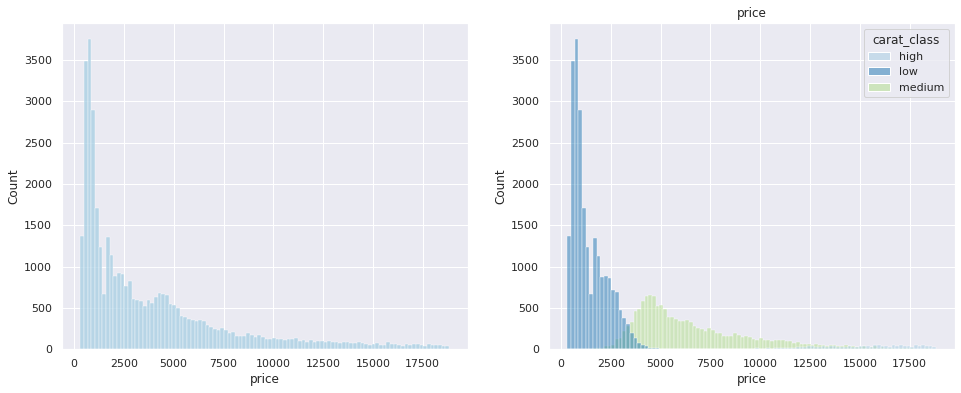

In [105]:
feature = 'price'
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Relevant statistical values:')
print(train[feature].describe())

fig,ax = plt.subplots(1,2, figsize = (16,6))
bins = 100
sns.histplot(data = train, x = feature, bins = bins, ax = ax[0])
sns.histplot(data = train, x = feature, hue = target, bins = bins, ax = ax[1])
plt.title("{}".format(feature));

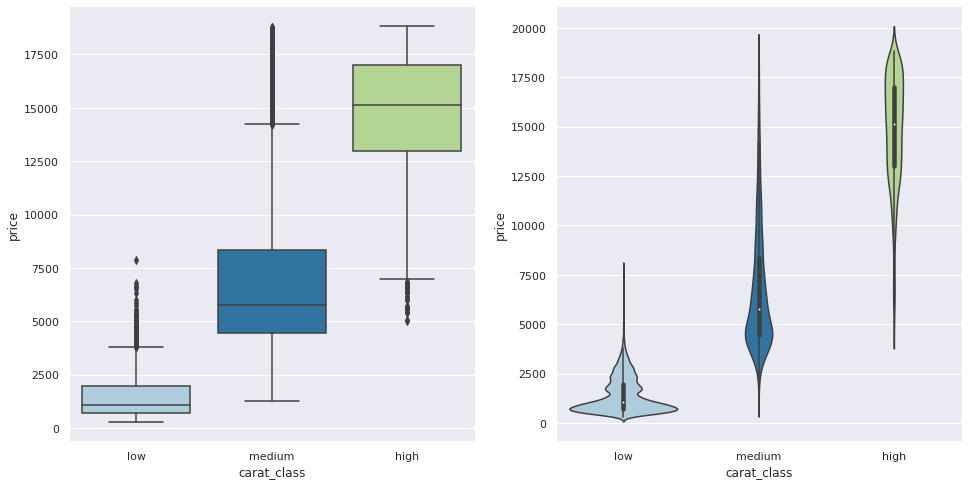

In [106]:
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

The IQR is:
4371.187864374814


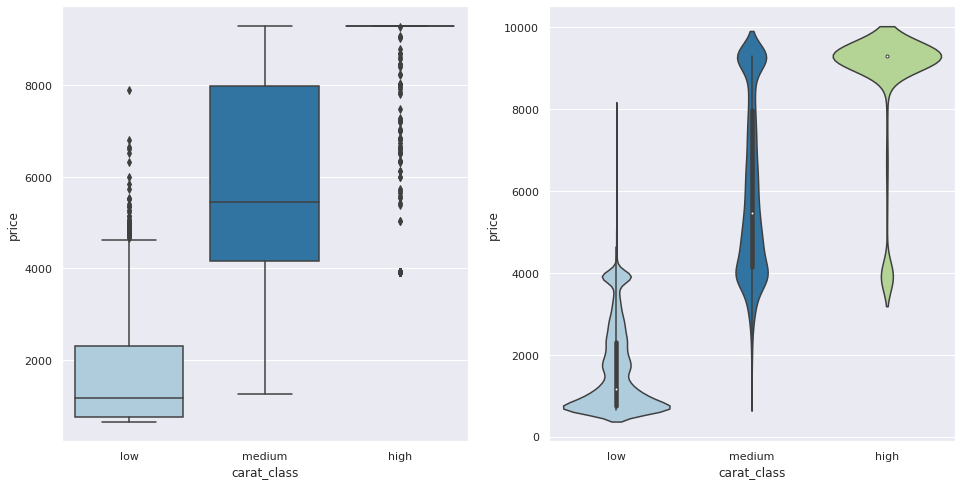

In [108]:
# interquantile range 
Q1 = train[feature].quantile(0.25)
Q3 = train[feature].quantile(0.75)
IQR = Q3 - Q1
print('The IQR is:')
print(IQR)

#NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mean()) # fill null values with the mean 
#tmp_df[feature] = train[feature].fillna(method = 'ffill') # fill null values with the mean 
        
#Anomalies
P10 = tmp_df[feature].quantile(0.1) 
P90 = tmp_df[feature].quantile(0.9) 
tmp_df[feature] = tmp_df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

## X analysis

Count of NULL values of "x" feature:
42
Relevant statistical values:
count    43128.000000
mean         6.730082
std          1.125322
min          0.935423
25%          5.703162
50%          6.684222
75%          7.546948
max         11.642644
Name: x, dtype: float64


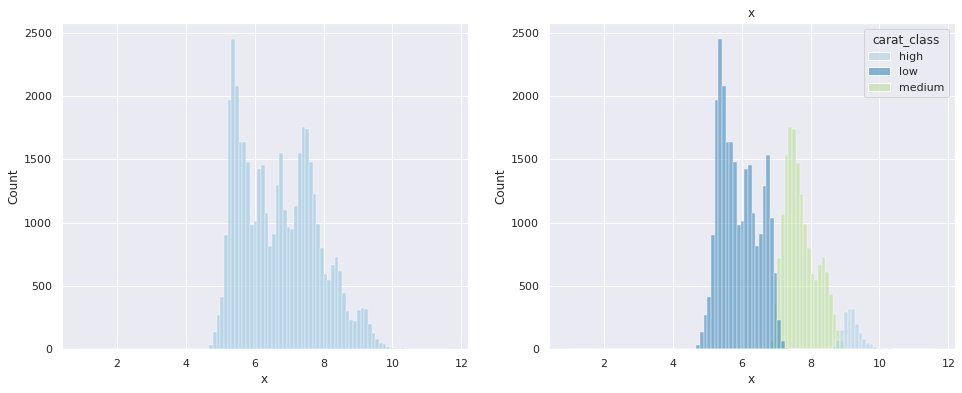

In [111]:
feature = 'x'
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Relevant statistical values:')
print(train[feature].describe())

fig,ax = plt.subplots(1,2, figsize = (16,6))
bins = 100
sns.histplot(data = train, x = feature, bins = bins, ax = ax[0])
sns.histplot(data = train, x = feature, hue = target, bins = bins, ax = ax[1])
plt.title("{}".format(feature));

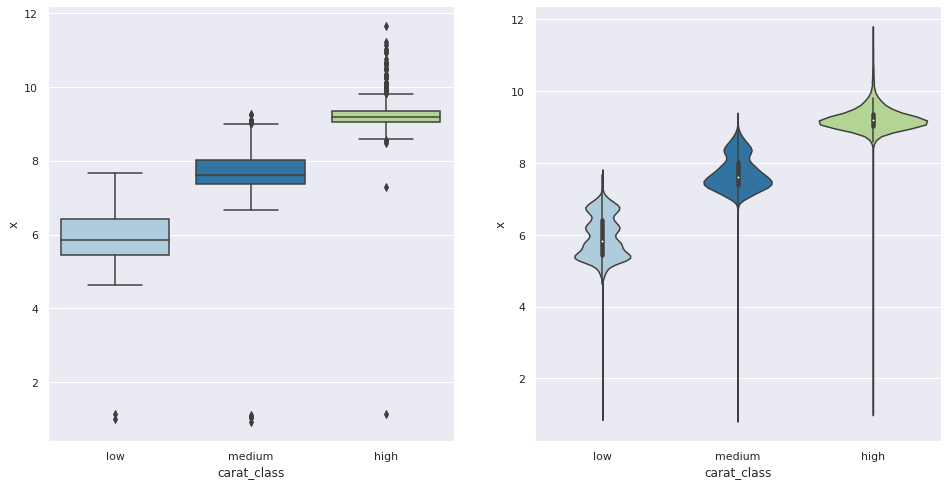

In [112]:
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

The IQR is:
1.843785851808411


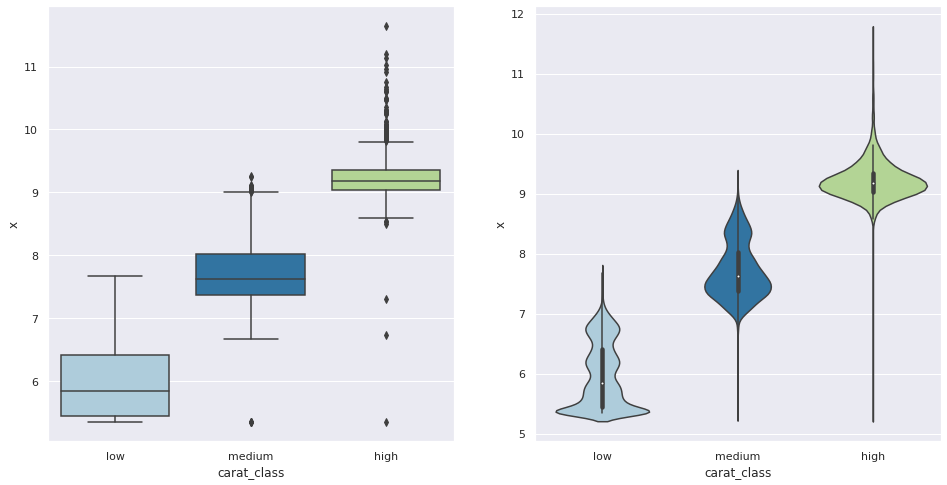

In [113]:
# interquantile range 
Q1 = train[feature].quantile(0.25)
Q3 = train[feature].quantile(0.75)
IQR = Q3 - Q1
print('The IQR is:')
print(IQR)

#NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mean()) # fill null values with the mean 
#tmp_df[feature] = train[feature].fillna(method = 'ffill') # fill null values with the mean 
        
#Anomalies
P10 = tmp_df[feature].quantile(0.1) 
P90 = tmp_df[feature].quantile(1) 
tmp_df[feature] = tmp_df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

Try to categorize the *x* feature in 3 categories (low, medium and high) and then print their value counts.

In [117]:
def categorize_x(x):
    to_return = None
    if x < 7:
        to_return = "low"
    elif x < 9:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

new_feat = feature+'_cat'
tmp_df[new_feat] = tmp_df[feature].apply(lambda x : categorize_x(x))
print('Value counts of' + feature +'categories:')
print(tmp_df[feature+'_cat'].value_counts())

print('Value counts of' + target +'categories:')
print(tmp_df[target].value_counts())

Value counts ofxcategories:
low       25329
medium    16391
high       1450
Name: x_cat, dtype: int64
Value counts ofcarat_classcategories:
low       25498
medium    15893
high       1779
Name: carat_class, dtype: int64


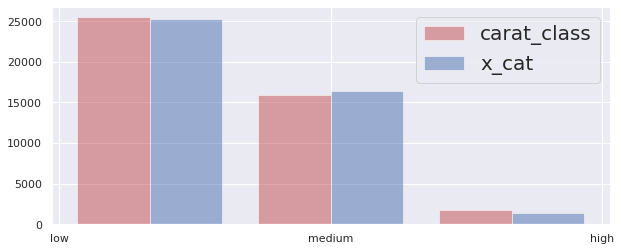

In [118]:
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','b']
plt.hist(tmp_df[['carat_class',new_feat]].to_numpy(), bins = 3,
         color=colors, alpha=0.5, label = ['carat_class',new_feat])
plt.legend(prop={'size': 20})
#plt.savefig("images/NumBike_NumBike1_comp1.png")
plt.show()

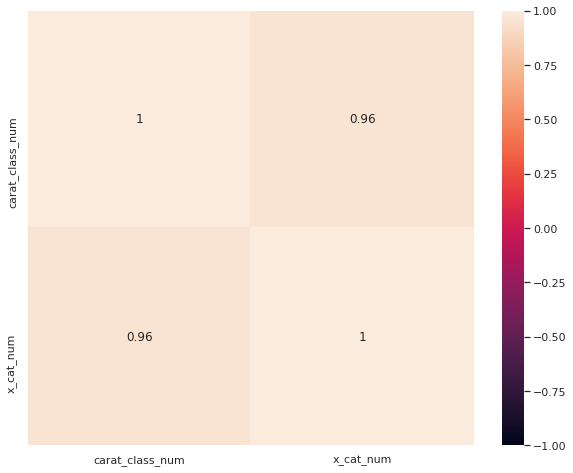

In [119]:
tmp_df[target+'_num'] = tmp_df[target].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
tmp_df[new_feat+'_num'] = tmp_df[new_feat].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes

tmp_df
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(tmp_df[[target+'_num',new_feat+'_num']].corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()


## Y analysis

Count of NULL values of "y" feature:
555
Relevant statistical values:
count    42615.000000
mean         5.733144
std          1.125156
min         -0.165995
25%          4.705580
50%          5.687529
75%          6.547369
max         10.542158
Name: y, dtype: float64


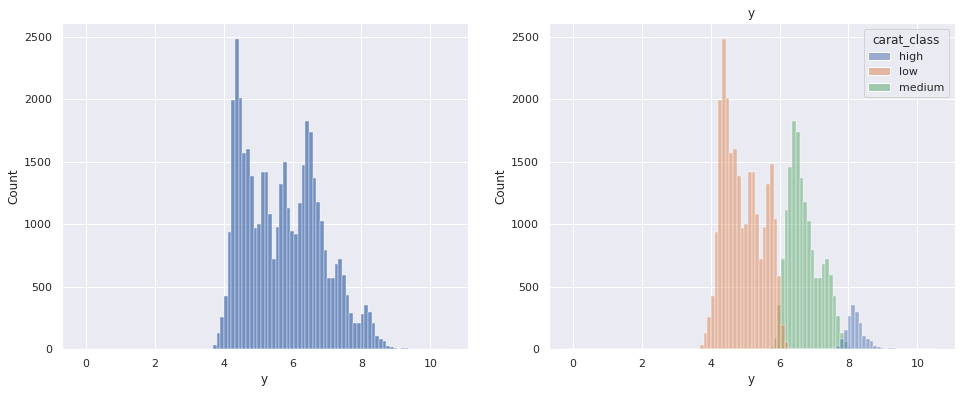

In [120]:
feature = 'y'
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Relevant statistical values:')
print(train[feature].describe())

fig,ax = plt.subplots(1,2, figsize = (16,6))
bins = 100
sns.histplot(data = train, x = feature, bins = bins, ax = ax[0])
sns.histplot(data = train, x = feature, hue = target, bins = bins, ax = ax[1])
plt.title("{}".format(feature));

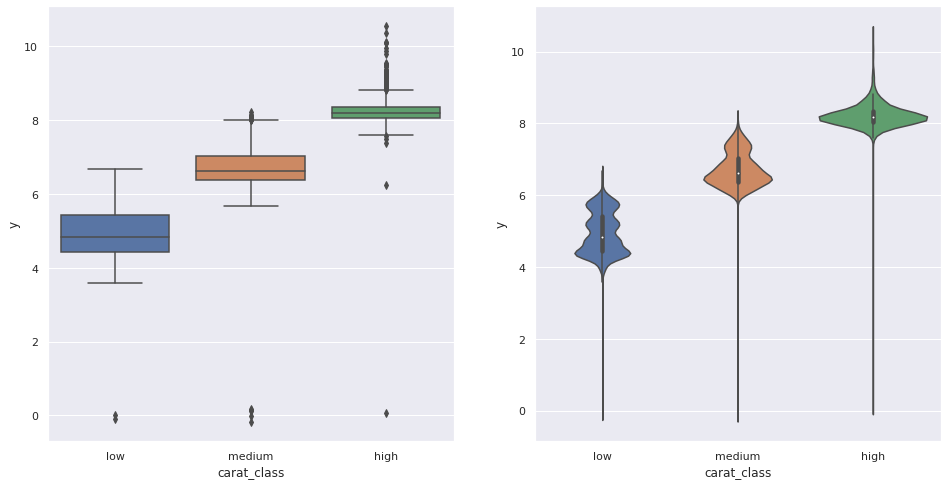

In [121]:
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

The IQR is:
1.8417887213901425


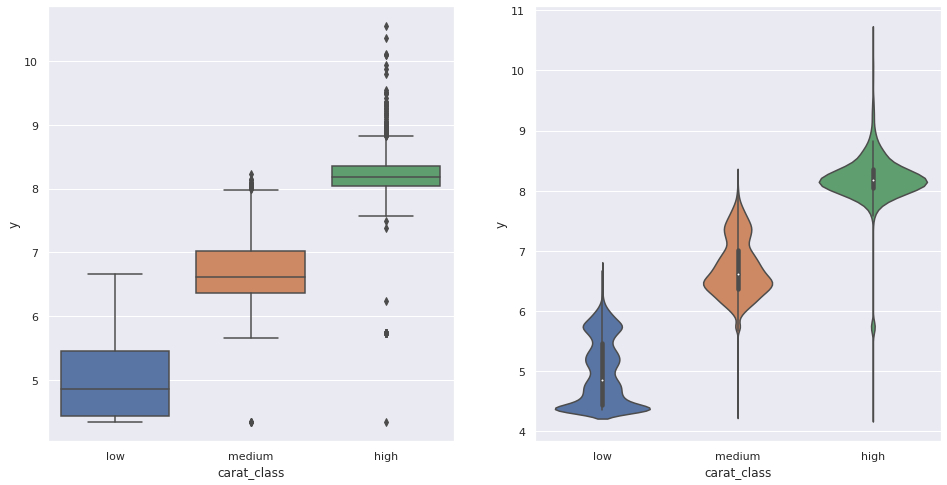

In [122]:
# interquantile range 
Q1 = train[feature].quantile(0.25)
Q3 = train[feature].quantile(0.75)
IQR = Q3 - Q1
print('The IQR is:')
print(IQR)

#NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mean()) # fill null values with the mean 
#tmp_df[feature] = train[feature].fillna(method = 'ffill') # fill null values with the mean 
        
#Anomalies
P10 = tmp_df[feature].quantile(0.1) 
P90 = tmp_df[feature].quantile(1) 
tmp_df[feature] = tmp_df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

Value counts ofycategories:
low       25508
medium    16229
high       1433
Name: y_cat, dtype: int64
Value counts ofcarat_classcategories:
low       25498
medium    15893
high       1779
Name: carat_class, dtype: int64


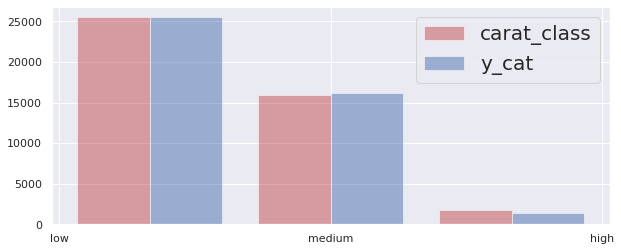

In [123]:
def categorize_y(y):
    to_return = None
    if y < 6:
        to_return = "low"
    elif y < 8:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return
  
new_feat = feature+'_cat'
tmp_df[new_feat] = tmp_df[feature].apply(lambda y : categorize_y(y))
print('Value counts of' + feature +'categories:')
print(tmp_df[feature+'_cat'].value_counts())

print('Value counts of' + target +'categories:')
print(tmp_df[target].value_counts())

plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','b']
plt.hist(tmp_df[['carat_class',new_feat]].to_numpy(), bins = 3,
         color=colors, alpha=0.5, label = ['carat_class',new_feat])
plt.legend(prop={'size': 20})
#plt.savefig("images/NumBike_NumBike1_comp1.png")
plt.show()

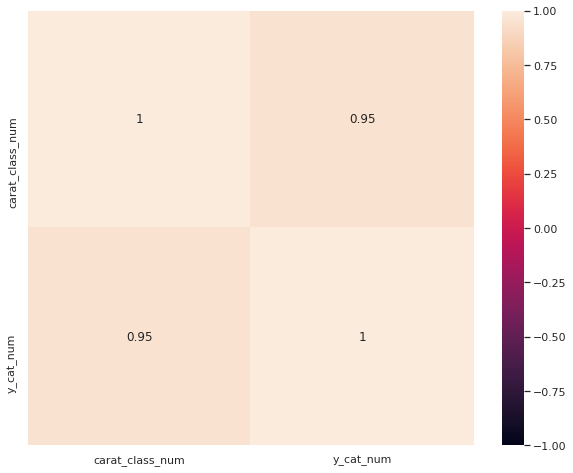

In [124]:
tmp_df[target+'_num'] = tmp_df[target].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
tmp_df[new_feat+'_num'] = tmp_df[new_feat].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes

tmp_df
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(tmp_df[[target+'_num',new_feat+'_num']].corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

## Z analysis

Count of NULL values of "z" feature:
843
Relevant statistical values:
count    42327.000000
mean         3.538764
std          0.724071
min         -0.253948
25%          2.917361
50%          3.499653
75%          4.057237
max         31.908393
Name: z, dtype: float64


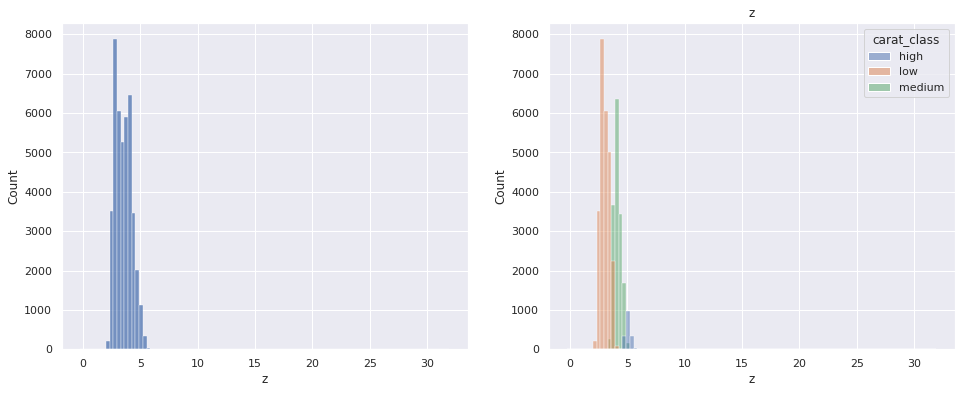

In [125]:
feature = 'z'
print('Count of NULL values of "'+feature+'" feature:')
print(train[feature].isnull().sum())
print('Relevant statistical values:')
print(train[feature].describe())

fig,ax = plt.subplots(1,2, figsize = (16,6))
bins = 100
sns.histplot(data = train, x = feature, bins = bins, ax = ax[0])
sns.histplot(data = train, x = feature, hue = target, bins = bins, ax = ax[1])
plt.title("{}".format(feature));

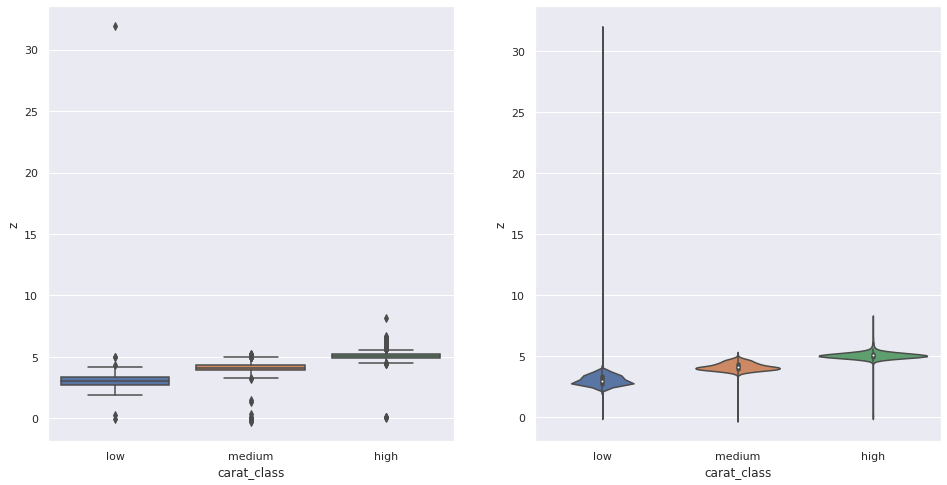

In [127]:
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=train, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

The IQR is:
1.1398759813846162


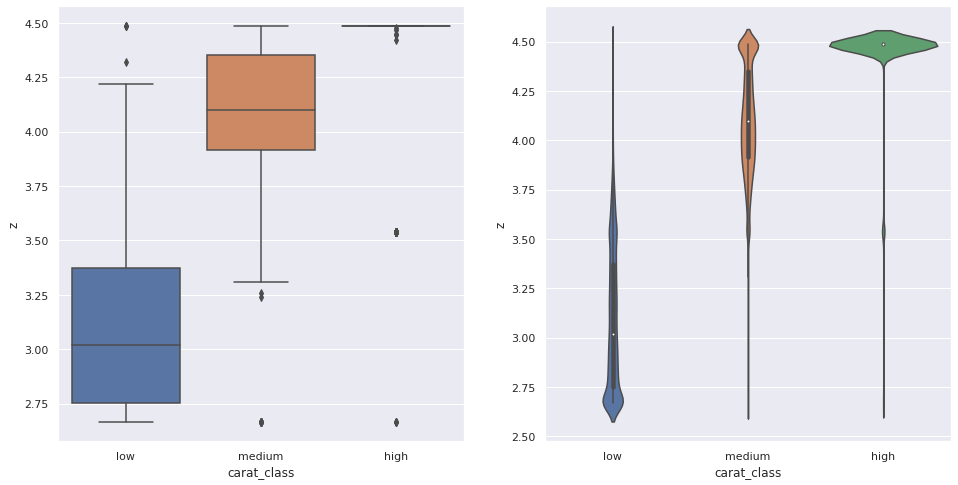

In [128]:
# interquantile range 
Q1 = train[feature].quantile(0.25)
Q3 = train[feature].quantile(0.75)
IQR = Q3 - Q1
print('The IQR is:')
print(IQR)

#NULL values
tmp_df[feature] = train[feature].fillna(train[feature].mean()) # fill null values with the mean 
#tmp_df[feature] = train[feature].fillna(method = 'ffill') # fill null values with the mean 
        
#Anomalies
P10 = tmp_df[feature].quantile(0.1) 
P90 = tmp_df[feature].quantile(0.9) 
tmp_df[feature] = tmp_df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
fig,ax = plt.subplots(1,2, figsize = (16,8))
sns.boxplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[0])
sns.violinplot(x= target, y= feature, data=tmp_df, order = ['low', 'medium','high'], ax = ax[1])
plt.show()

## Encode 'carat_class'

In [129]:
tmp_df[target] = tmp_df[target].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes

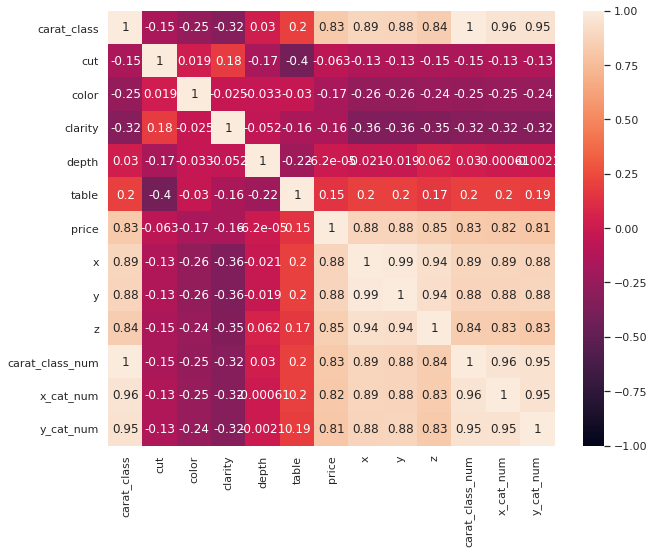

In [131]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(tmp_df.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

# Pre-process

In [132]:
def preprocess(df, df_ref, label = True):

    """
    This function allow to customize your preprocessing in order to have data ready for training process
    """
    print('Before dropping duplicates the dataset has {} rows.'.format(df.shape[0]))
    df = df.drop_duplicates().reset_index(drop=True) # drop duplicates 
    
    print('After dropping duplicates the dataset has {} rows.'.format(df.shape[0]))
    
    num_features = ['depth','table','price','x','y','z']
    qualitative_features = ['cut','color','clarity']
    target_feature = 'carat_class'
    
    orders = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
              ['J','I','H','G','F','E','D'],
              ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']]
    
    quantiles = [[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,1.],[0.1,1.],[0.1,0.9]]
    
    for feature,quant in zip(num_features,quantiles):
        #NULL values
        df[feature] = df[feature].fillna(df_ref[feature].mean()) # fill null values with the mean 
        
        #Anomalies
        P10 = df[feature].quantile(quant[0]) 
        P90 = df[feature].quantile(quant[1]) 
        df[feature] = df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
        
    for feature,order in zip(qualitative_features,orders):
        #NULL values
        df[feature] = df[feature].fillna(df_ref[feature].mode()[0]) # fill null values with the mode 
        
        #Encoding
        df[feature] = df[feature].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes


    if label: 
        #Encoding
        df[target_feature] = df[target_feature].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes

    return df

In [133]:
prep_train = preprocess(train, train)
prep_train.head()

Before dropping duplicates the dataset has 43170 rows.
After dropping duplicates the dataset has 43170 rows.


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [134]:
display(train['carat_class'].value_counts())
display(prep_train['carat_class'].value_counts())

low       25498
medium    15893
high       1779
Name: carat_class, dtype: int64

0    25498
1    15893
2     1779
Name: carat_class, dtype: int64

In [135]:
prep_test = preprocess(test, train, label = False)
prep_test.head()

Before dropping duplicates the dataset has 10770 rows.
After dropping duplicates the dataset has 10770 rows.


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,NaN,2,2,4,59.836140,60.324462,647.878069,5.356124,4.352648,2.673524
1,NaN,1,0,2,63.571754,54.854762,647.878069,5.356124,4.352648,2.687131
2,NaN,4,0,4,63.515610,56.243782,647.878069,5.356124,4.352648,2.673524
3,NaN,3,5,1,60.521578,60.324462,647.878069,5.356124,4.352648,2.673524
4,NaN,3,5,0,60.880893,57.886154,647.878069,5.500656,4.425004,2.825893


# Save data in the bucket

In [20]:
import io
import boto3


#Path files of the dataframe
train_path_file = 'preprocess/prep_train.csv'

#Put dataframes to S3
csv_buffer = io.StringIO()
prep_train.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)
boto3.resource('s3').Object(bucket, train_path_file).put(Body=csv_buffer.getvalue())

#Path files of the dataframe
test_path_file = 'preprocess/prep_test.csv'

#Put dataframes to S3
csv_buffer = io.StringIO()
prep_test.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)
boto3.resource('s3').Object(bucket, test_path_file).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'HF32C9TYHRM964NX',
  'HostId': 'LkTh0+lAsfMd2bQQAyIDSx4FEIn6G3DIeD2DmBsSHsZU6I97dbKfMcxCDrz+zbOgpkTuHtkz2i4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'LkTh0+lAsfMd2bQQAyIDSx4FEIn6G3DIeD2DmBsSHsZU6I97dbKfMcxCDrz+zbOgpkTuHtkz2i4=',
   'x-amz-request-id': 'HF32C9TYHRM964NX',
   'date': 'Wed, 07 Jul 2021 12:45:20 GMT',
   'etag': '"e6a966a6de4e8617d640d306fd77aac4"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"e6a966a6de4e8617d640d306fd77aac4"'}